In [2]:
# Importing the libraries and functions from model.py file
from stage1 import *

In [3]:
# load water molecules and frames from xtc file and gro file
all_frames = md.load_xtc("../simulation/single_melt/eql2.xtc",top="../simulation/single_melt/h2o.pdb")


In [4]:
# Extracting the first frame from the xtc file
molecule = all_frames[0]
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms] 
water = Atoms(positions= molecule.xyz[0], numbers=atomic_nums)

In [5]:
# Calculating the feature matrix for each frame in the xtc file
frames = all_frames
features = []
for molecule in tqdm(frames):
    atomic_nums = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T
    vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T
    mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T
    positions = molecule.xyz[0]*10
    
    positions = positions - positions[0]
    
    node_features = np.concatenate((positions,vdwr,atomic_nums),axis=1)
    features.append(node_features)
    
features = np.array(features)

100%|██████████| 50001/50001 [00:01<00:00, 47728.69it/s]


In [6]:
# Printing node features for testing purposes
print("Node Features:\n",features[10])

Node Features:
 [[ 0.          0.          0.          0.152       8.        ]
 [-0.42058086  0.64916897  0.5638485   0.12        1.        ]
 [-0.62055779 -0.13362885 -0.71643734  0.12        1.        ]
 [-0.11106586  0.05499649 -0.01627827  0.          0.        ]]


In [7]:
# creating edge list for the graph nodes
from_list = []
to_list = []
for edge in all_frames.topology.bonds:
    from_list.append(edge.atom1.index)
    to_list.append(edge.atom2.index)
    from_list.append(edge.atom2.index)
    to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [8]:
# appending graphs to a list
graphs=[]
for node_feature in tqdm(features):
    graph = data.Data(x=torch.from_numpy(node_feature),edge_index=torch.from_numpy(edge_list))
    graphs.append(graph)
    

100%|██████████| 50001/50001 [00:00<00:00, 64150.85it/s]


In [9]:
print(graphs[0]) 
# features per node positions and vanderwaals radius and atomic number
# edge index is the edge list of the graph

Data(x=[4, 5], edge_index=[2, 4])


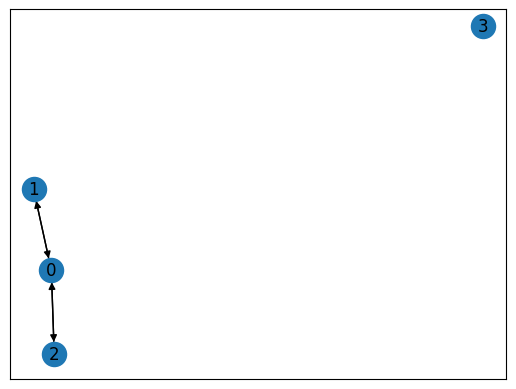

In [10]:
# Visualizing the graph network
vis = to_networkx(graphs[0])
nx.draw_networkx(vis, with_labels=True)


In [11]:
# using cuda if available
# and moving the graphs to the device
# using whichever is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graphs_device = []
for graph in tqdm(graphs):
    graphs_device.append(graph.to(device))

100%|██████████| 50001/50001 [00:00<00:00, 216816.00it/s]


In [12]:
import os
in_channels = graph.num_features
out_channels = 3
n_atoms = 4
lr = 1e-3
n_epochs = 500
batch_size=128
test_train_split = 0.8
model_name = "model1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.exists("./models/"+model_name) and not force_train:
    model = torch.load("./models/"+model_name)
    model_loaded = True
else:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels,batch_size,n_atoms),
                VariationalGCNDecoder(out_channels, in_channels,batch_size,n_atoms))
    
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [13]:
split = int(test_train_split * len(graphs_device))
train_loader = DataLoader(graphs_device[:split], batch_size=batch_size,shuffle=True)
test_loader = DataLoader(graphs_device[split:], batch_size=batch_size,shuffle=True)

In [14]:
print("Using:",device )
print("total_graphs:", len(graphs_device))
print("Graphs in a batch:", batch_size)
print("Train Graphs Batches:",len(train_loader),f"(Total graphs: {len(train_loader)*batch_size})")
print("Test Graphs Batches:",len(test_loader),f"(Total graphs: {len(test_loader)*batch_size})")
print("Model Specifics:\n",model)

Using: cpu
total_graphs: 50001
Graphs in a batch: 128
Train Graphs Batches: 313 (Total graphs: 40064)
Test Graphs Batches: 79 (Total graphs: 10112)
Model Specifics:
 VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)


In [15]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        
        # heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
     
        
        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]


        positionLoss = lossFxn(decoded_pos, orignal_pos)
        FeatureLoss = lossFxn(decoded_features, orignal_features)
        loss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)


        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)

#         positionLoss.backward()
        loss.backward()
        optimizer.step()

    return loss_all / len(train_loader), feature_loss_all / len(train_loader), edge_loss_all / len(train_loader) ,position_loss_all / len(train_loader)

In [16]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.double()
    
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]
        
        
        # heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
   
        
        positionLoss = lossFxn(decoded_pos, orignal_pos)
        FeatureLoss = lossFxn(decoded_features, orignal_features)
        loss = lossFxn(decoded_x, data.x)

        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)



    return loss_all / len(test_loader), feature_loss_all / len(test_loader), edge_loss_all / len(test_loader), position_loss_all / len(test_loader)

In [17]:
train_total_losses = []
train_feature_losses = []
train_edge_losses = []
train_position_losses = []

test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_position_losses = []

early_stopper = EarlyStopper(patience=3, min_delta=10)


if model_loaded:        
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):
        train_total_loss, train_feature_loss, train_edge_loss,train_position_loss = train()
        test_total_loss, test_feature_loss, test_edge_loss,test_position_loss = test()
        
        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tTotal Loss: {train_total_loss:.4f}, Feature Loss: {train_feature_loss:.4f}, Position Loss: {train_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        print(f'\tTest: \tTotal Loss: {test_total_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Position Loss: {test_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
        if(early_stopper.early_stop(test_total_loss)):
            print("Early Stopping")
            break

        train_total_losses.append(train_total_loss)
        train_feature_losses.append(train_feature_loss)
        train_edge_losses.append(train_edge_loss)
        train_position_losses.append(train_position_loss)

        test_total_losses.append(test_total_loss)
        test_feature_losses.append(test_feature_loss)
        test_edge_losses.append(test_edge_loss)
        test_position_losses.append(test_position_loss)
        
        scheduler.step()

    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	Total Loss: 0.7879, Feature Loss: 1.7386, Position Loss: 0.1540, LR: 0.001000
	Test: 	Total Loss: 0.0928, Feature Loss: 0.0009, Position Loss: 0.1540, LR: 0.001000
Epoch: 002
	Train:	Total Loss: 0.0933, Feature Loss: 0.0021, Position Loss: 0.1540, LR: 0.001000
	Test: 	Total Loss: 0.0927, Feature Loss: 0.0007, Position Loss: 0.1540, LR: 0.001000
Epoch: 003
	Train:	Total Loss: 0.0930, Feature Loss: 0.0014, Position Loss: 0.1540, LR: 0.001000
	Test: 	Total Loss: 0.0928, Feature Loss: 0.0010, Position Loss: 0.1540, LR: 0.001000
Epoch: 004
	Train:	Total Loss: 0.0930, Feature Loss: 0.0013, Position Loss: 0.1541, LR: 0.001000
	Test: 	Total Loss: 0.0938, Feature Loss: 0.0034, Position Loss: 0.1541, LR: 0.001000
Epoch: 005
	Train:	Total Loss: 0.0929, Feature Loss: 0.0012, Position Loss: 0.1541, LR: 0.001000
	Test: 	Total Loss: 0.0928, Feature Loss: 0.0009, Position Loss: 0.1540, LR: 0.001000
Epoch: 006
	Train:	Total Loss: 0.0928, Feature Loss: 0.0011, Position Loss: 0.1540, L

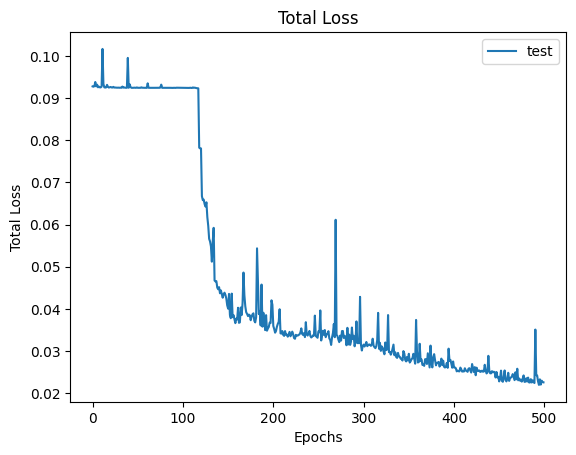

In [18]:
plt.plot(test_total_losses,label="test")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.legend()
plt.title("Total Loss")
plt.savefig("./plots/"+model_name+"_total_loss.png")
plt.show()


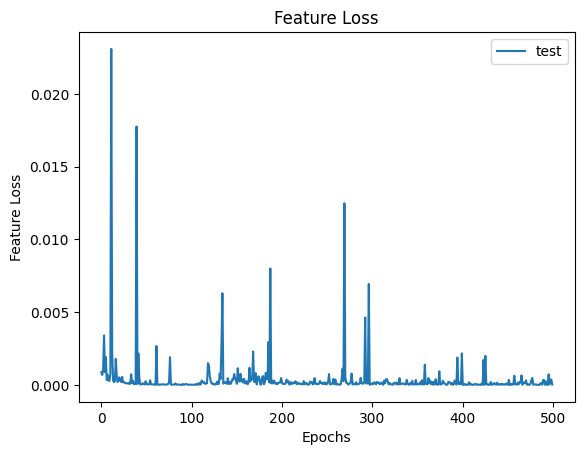

In [19]:
# train vs test feature loss

plt.plot(test_feature_losses,label="test")
plt.xlabel("Epochs")
plt.ylabel("Feature Loss")
plt.legend()
plt.title("Feature Loss")
plt.savefig("./plots/"+model_name+"_feature_loss.png")
plt.show()


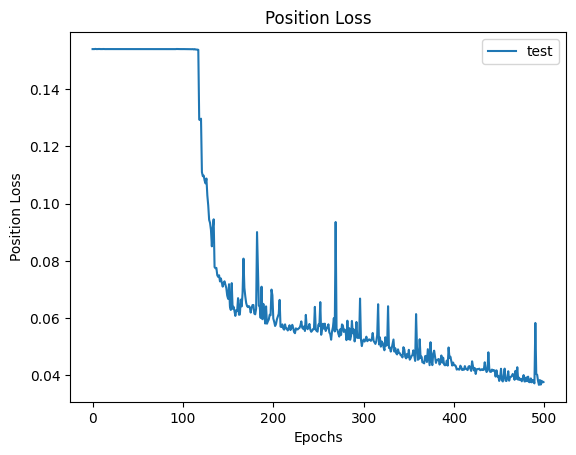

In [20]:
# train vs test position loss
# plt.plot(train_position_losses,label="train")
plt.plot(test_position_losses,label="test")
plt.xlabel("Epochs")
plt.ylabel("Position Loss")
plt.legend()
plt.title("Position Loss")
plt.savefig("./plots/"+model_name+"_position_loss.png")
plt.show()


In [21]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()
    # heavy indices here are the indices of the heavy atoms in the graph that is the atoms that are not hydrogen
    # write a function to calculate the error including the hydrogen atoms
    Error_w_s = F.mse_loss(decoded_x, test_graph.x).detach().cpu().numpy()


    avg1 += Error_wo_s
    avg2 += Error_w_s

print("Average Error without hydrogen - ", avg1/len(test_loader))
print("Average Error with hydrogen - ", avg2/len(test_loader))

Average Error without hydrogen -  0.00015846769706507274
Average Error with hydrogen -  0.021254988228330995


In [22]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
print(decoded_feature[0][heavy_indices],input_feature[0][heavy_indices])
# tried to print the decoded feature and the input feature for the first graph in the test loader
# only the heavy atoms are printed
# now we need to print the hydrogen atoms as well
# we have the indices of the hydrogen atoms in the heavy indices variable

decoded_feature[0],input_feature[0]

tensor([[-3.3091e-03, -4.5823e-03, -3.1011e-03,  1.5202e-01,  8.0170e+00]],
       dtype=torch.float64, grad_fn=<IndexBackward0>) tensor([[0.0000, 0.0000, 0.0000, 0.1520, 8.0000]], dtype=torch.float64)


(tensor([[-3.3091e-03, -4.5823e-03, -3.1011e-03,  1.5202e-01,  8.0170e+00],
         [-4.9928e-01, -5.2054e-01, -3.4325e-01,  1.1836e-01,  9.9924e-01],
         [-2.0412e-01, -1.7326e-01,  6.5751e-01,  1.1938e-01,  1.0144e+00],
         [-6.5138e-03, -4.7004e-03, -1.2945e-03, -1.5626e-04, -6.8248e-04]],
        dtype=torch.float64, grad_fn=<LeakyReluBackward0>),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.1520,  8.0000],
         [-0.2133, -0.8890, -0.2836,  0.1200,  1.0000],
         [-0.6440,  0.1959,  0.6805,  0.1200,  1.0000],
         [-0.0915, -0.0739,  0.0423,  0.0000,  0.0000]], dtype=torch.float64))

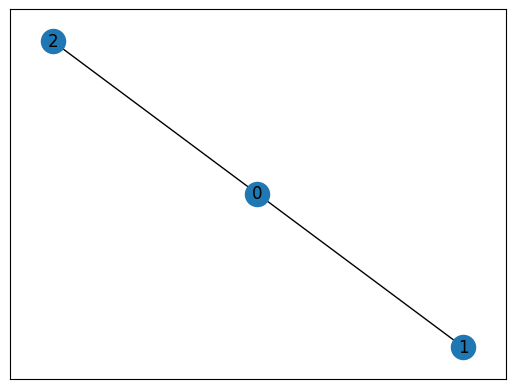

In [23]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


In [24]:
def plotCompare(features1,features2):
    # %matplotlib widget
    xyz1 = features1[:,-3:]
    xyz2 = features2[:,-3:]
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(xyz1[:,0],xyz1[:,1],xyz1[:,2],label="output")
    ax1.scatter(xyz2[:,0],xyz2[:,1],xyz2[:,2],label="input")
    plt.legend()
    plt.show()

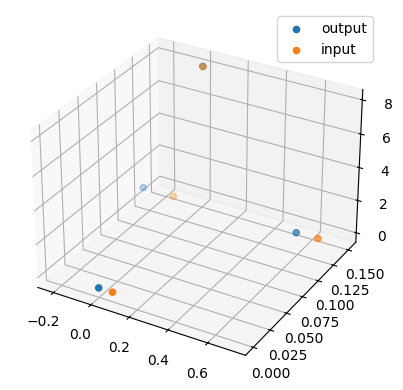

In [25]:
plotCompare(decoded_feature[1].detach().numpy(),input_feature[1].detach().numpy())


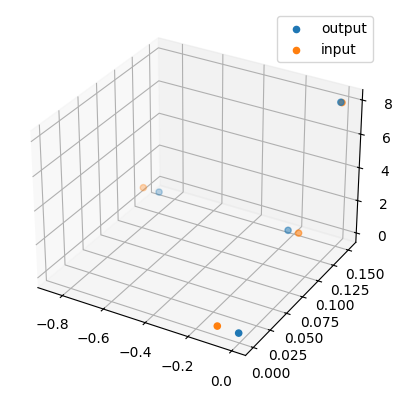

In [26]:
plotCompare(decoded_feature[15].detach().numpy(),input_feature[15].detach().numpy())

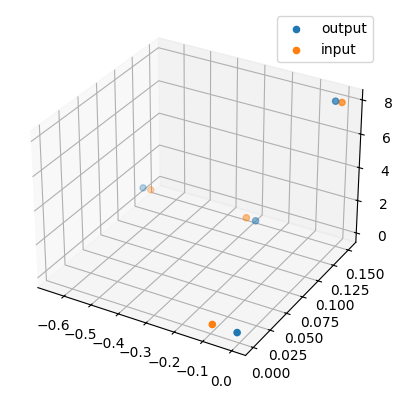

In [27]:
plotCompare(decoded_feature[39].detach().numpy(),input_feature[39].detach().numpy())

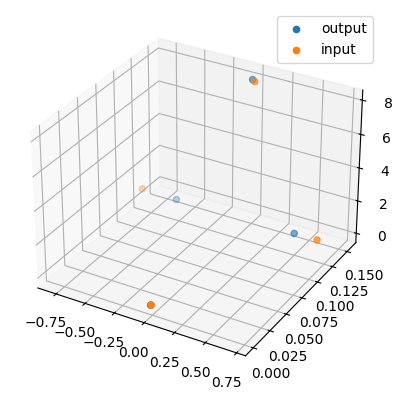

In [28]:
plotCompare(decoded_feature[78].detach().numpy(),input_feature[78].detach().numpy())